# Sparkify - Data Sciene Capstone

## Project

Sparkify is a music streaming service similar to Google Music or Amazon Music. The data provided is an activity log of a subset of users. The activity log includes information such as the page visited, actions take, type of browser used, first name, last name and other variables. The scope of this project is to create a machine learning model that can predict users who churn (users who opt out of the service). This is important for a business which relies on customer subscriptions to generate revenue and maintain a presence in the market.
<br>

The steps followed in this notebook are:
#### Initial setup
- Importing Libraries

#### ETL
- Loading the Data From AWS S3
- Glance at Data
- Looking for Missing Values
- Data Balance (looking for under-represented data)
- Feature Extraction

#### EDA
- Feature Correlations
- Differences Amongst Users

#### Machine Learning Pipeline
- Pipeline & Metrics
- Models
- Fitting
- Predicting

#### Results
- Performance
- Compare Models

#### Discussion
- What do the results mean?
- What can we learn from the models?

#### Other Notes
How I set up the problem to save as much money as I could.
- installed spark on my local Linux machine
- installed aws service on my machine
- downloaded the small snippet of data on my local linux machine to later run on the large dataset

## Importing Libraries

The main library I will be using is pyspark with the intention of running it on an AWS EMR cluster, as the data is roughly 16GB and cannot be loaded on the memory of most computers all at once (there are steps to load data in chunks, but that is beyond the scope of this project). I will be using PySpark for loading the data, cleaning, feature extraction as well as the machine learning. <br>
For some of the EDA I will be using Pandas, Numpy, Matplotlib and Seaborn; after feature extraction I expect the data size to be reduced significantly such that it can be loaded in the memory. Once the data becomes easier to read on memory it will be easier to use pandas and the other graphic libraries to display the results.

In [13]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import types as T
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset


## Import Data

I originally imported the small dataset named <code><b>mini_sparkify_event_data.json</b></code>, I used the smaller dataset in order to develop my initial workflow on my local computer. When I was close to finishing my project I used the full dataset on the AWS EMR cluster. <br>

In [16]:
event_data = "/home/juggernaut/Documents/mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.createOrReplaceTempView("data")
print('shape of data is {}, {}'.format(df.count(),len(df.columns)))

shape of data is 286500, 18


What does the data look like? Looking at the schema will be useful to understand the columns.

In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



What does one entry look like?

In [24]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

We can see that each row contains information that can be very useful, such as level, page and some that we do not know how useful it would be such as gender, ts and itemInSession. There are also columns that I will not use such as firstName, lastName, location, method, registration, status, userAgent. <br>
<b>userId</b> will be the key used to pull features for each user.

### can we drop Nans? I think there are None, # blessed

In [4]:
df.dropna()
print('shape of data is {}, {}'.format(df.count(),len(df.columns)))
# there are no NaNs

shape of data is 286500, 18


DROP THE PESKY COLUMNS

In [5]:
drop_columns =['artist', 'firstName','lastName','song']
for col in drop_columns:
    df.drop(col)

### Simplest feature engineering of my life
using a custom function to transform the fact that the sub-downgrades into either a 1 for churned or 0

In [6]:
labeler = lambda x: 1 if x>0 else 0
labelfunc = F.udf(labeler,IntegerType())
pdf=spark.sql('''
SELECT userId,
gender,
COUNT(page) AS n_pages,
COUNT(IF(page='Cancel',1,NULL)) AS n_cancel,
COUNT(IF(page='Submit Downgrade',1,NULL)) AS n_sub_downgrade,
COUNT(IF(page='Thumbs Down',1,NULL)) AS n_thumb_down,
COUNT(IF(page='Home',1,NULL)) AS n_home,
COUNT(IF(page='Downgrade',1,NULL)) AS n_downgrade,
COUNT(IF(page='Roll Advert',1,NULL)) AS n_roll_advert,
COUNT(IF(page='Cancellation Confirmation',1,NULL)) AS n_cancellation,
COUNT(IF(page='About',1,NULL)) AS n_about,
COUNT(IF(page='Submit Registration',1,NULL)) AS n_submit_registration,
COUNT(IF(page='Cancel',1,NULL)) AS n_cancel,
COUNT(IF(page='Login',1,NULL)) AS n_login,
COUNT(IF(page='Register',1,NULL)) AS n_register,
COUNT(IF(page='Add to Playlist',1,NULL)) AS n_add_playlist,
COUNT(IF(page='NextSong',1,NULL)) AS n_nextsong,
COUNT(IF(page='Thumbs Up',1,NULL)) AS n_thumb_up,
COUNT(IF(page='Error',1,NULL)) AS n_error,
COUNT(IF(page='Submit Upgrade',1,NULL)) AS n_submit_upgrade,
SUM(length) AS total_length
FROM data GROUP BY userId,gender''')
pdf.createOrReplaceTempView("features")
pdf_labeled = pdf.withColumn("label",labelfunc("n_sub_downgrade"))

### This is a fairly small set, we can use this in pandas

In [10]:
featuredf = pdf_labeled.toPandas()

In [7]:
all_df=df.toPandas()

In [8]:
all_df[(all_df['userId']=='39') & (all_df['page']=='Submit Downgrade')]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
121250,None,Logged In,Payton,F,27,Campbell,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,Submit Downgrade,1.529028e+12,1546,None,307,1541255372000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39
124002,None,Logged In,Payton,F,59,Campbell,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,Submit Downgrade,1.529028e+12,1609,None,307,1541357937000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39
165515,None,Logged In,Payton,F,171,Campbell,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,Submit Downgrade,1.529028e+12,1985,None,307,1542419388000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39


In [11]:
featuredf[featuredf['label']==0][['userId','n_sub_downgrade', 'label']]

,userId,n_sub_downgrade,label
0,44,0,0
1,46,0,0
2,41,0,0
3,72,0,0
6,100010,0,0
...,...,...,...
220,47,0,0
221,27,0,0
222,124,0,0
224,151,0,0


In [12]:
train = pdf_labeled.sampleBy("label",fractions={0:0.8,1:0.8},seed=1)

In [13]:
test=pdf_labeled.subtract(train)

In [14]:
test.count()

42

In [15]:
train.count()

184

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler

In [17]:
assembler = VectorAssembler(inputCols=['n_thumb_down',
                                      'n_home',
                                      'n_roll_advert',
                                      'n_about',
                                      'n_submit_registration',
                                      'n_login',
                                      'n_add_playlist',
                                      'n_nextsong',
                                      'n_thumb_up',
                                      'n_error',
                                      'n_submit_upgrade'],outputCol='features')
pdf_labeled=assembler.transform(pdf_labeled)

In [18]:
gbt = GBTClassifier(labelCol='label', featuresCol= 'features',  maxIter=10)
gbtmodel=gbt.fit(pdf_labeled)

In [19]:
predictions=gbtmodel.transform(assembler.transform(test))

In [20]:
predictions.select('label','prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

In [22]:
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, 
                               {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [118]:
trainsummary=gbtmodel.featureImportances

In [23]:
lr = LogisticRegression(labelCol='label', featuresCol= 'features',  maxIter=10)
lrmodel=lr.fit(pdf_labeled)

In [24]:
predictions = lrmodel.transform(assembler.transform(test))

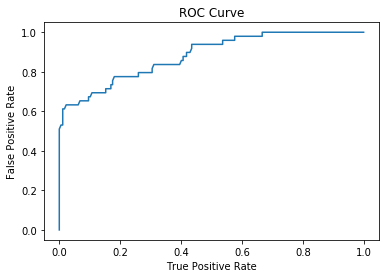

Training set areaUnderROC: 0.8826242361351319


In [25]:
import numpy as np
import matplotlib.pyplot as plt
trainingSummary = lrmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

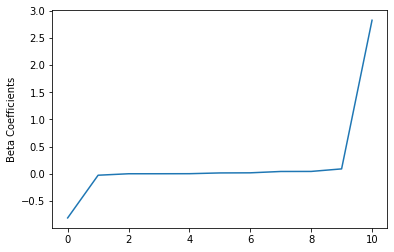

In [26]:
beta = np.sort(lrmodel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [28]:
testingSummary = predictions.summary
roc = testingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Testing set areaUnderROC: ' + str(testingSummary.areaUnderROC))

AttributeError: 'function' object has no attribute 'roc'

In [29]:
trainingSummary

In [31]:
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, 
                               {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9120370370370371


In [1]:
import numpy as np

In [2]:
ls

ETL.ipynb


In [6]:
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv('../../Downloads/turnover.csv')

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


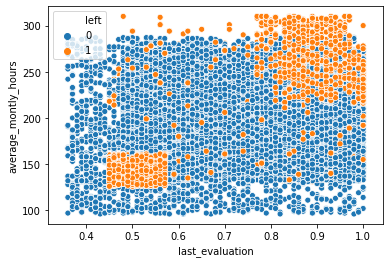

In [11]:
sns.scatterplot(x='last_evaluation',y='average_montly_hours',hue='left',data=df)